In [1]:
from utils import TempRWE_Encoder

from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

from sklearn.metrics import f1_score, accuracy_score, classification_report
import os
import pandas as pd
import numpy as np

import joblib

root = "C:/Users/tas/Desktop/RNN/dataset/"

In [2]:
WAVELET = "bior1.3"

In [3]:
data = joblib.load(root + "/train\data-multi-train-fixed.joblib")
print(data.shape)
dec = TempRWE_Encoder(maxcurrent=500, wavename=WAVELET, maxlevel=6)

data_train = dec.decompose(data)
print(data_train.shape)
labels_train_bin = joblib.load(root + "/train/labels-bin-train-fixed.joblib")
print(labels_train_bin.shape)


(3941, 5601)
(3941, 98)
(3941,)


In [4]:
splitter = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

grid = {
    "max_depth":                [2, 7, 20],   
    "min_child_weight":         [1, 10, 25],      
    "n_estimators":             np.arange(50, 405, 10),  
    "learning_rate":            [0.1, 0.01, 0.001], 
    # "subsample":                [0.8, 1.0],     
    # "colsample_bytree":         [0.8, 1.0],     
    "gamma":                    [0.1],  
}

# DTC = DecisionTreeClassifier(random_state=3647)

searcher = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=grid,
    cv=splitter, 
    scoring="f1_weighted", 
    refit = True, 
    n_jobs=-1, 
    verbose=10)

In [5]:
searcher.fit(X=data_train, y=np.array(labels_train_bin).ravel())


Fitting 5 folds for each of 972 candidates, totalling 4860 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=No...
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.1], 'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [2, 7, 20],
                         'min_child_weight': [1, 10, 25],
                         'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300,
       310, 320, 330, 340, 350, 360, 370, 380, 390, 400])},
             scoring='f1_weighted', verbose=10)

In [6]:
searcher.best_params_

{'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 170}

In [7]:
print(f"Best score: {searcher.best_score_*100:.3f}%")

Best score: 94.475%


In [8]:
os.makedirs("./grid-search-results/", exist_ok  = True)
joblib.dump(searcher, f"./grid-search-results/xgb_searcher_hard_{WAVELET}_TempRWE.joblib")
pass

### METRICS ON TEST SET

In [9]:
xgb = searcher.best_estimator_

In [12]:
data = joblib.load(root + "test\data-multi-test-fixed.joblib")

data_test = dec.decompose(data)
labels_test_bin = joblib.load(root + "test/labels-bin-test-fixed.joblib")

In [13]:
y_preds = xgb.predict(data_test)
F1TEST = f1_score(y_true=labels_test_bin, y_pred=y_preds)
ACCTEST = accuracy_score(y_true=labels_test_bin, y_pred=y_preds)
print(f"Test F1-SCORE:  {F1TEST*100:.3f}%")
print(f"Test ACC-SCORE: {ACCTEST*100:.3f}%")
print(classification_report(y_true=labels_test_bin, y_pred=y_preds, digits=5))

Test F1-SCORE:  87.291%
Test ACC-SCORE: 89.599%
              precision    recall  f1-score   support

       False    0.92509   0.89924   0.91198      1181
        True    0.85541   0.89114   0.87291       790

    accuracy                        0.89599      1971
   macro avg    0.89025   0.89519   0.89244      1971
weighted avg    0.89716   0.89599   0.89632      1971



In [14]:
from sklearn.metrics import RocCurveDisplay
from matplotlib import pyplot as plt

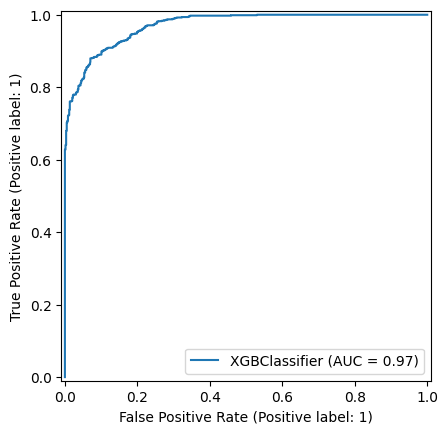

In [15]:
RocCurveDisplay.from_estimator(xgb, data_test, labels_test_bin)
plt.show()